In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import statsmodels.api as sm
import sys
import os
sys.path.append(os.path.abspath("NAICS6_Pyfunctions/"))
import importlib
import EmploymentFunctions as empfunc
from getAggLevelSummaries import *
import WageFunctions as wagefunc
import get_microdata as getmd
# from NAICS6functions import *
DATASETloc = "DataDiag/PythonPreprocessOut/combineQWIandCBP.csv"
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
importlib.reload(empfunc)  # Force-reload the module
importlib.reload(wagefunc)  # Force-reload the module

<module 'WageFunctions' from '/home/fundeofnuts/Documents/Sesa/SyntheticEstablishmentData/WorkingDir/6naicstudy/NAICS6_Pyfunctions/WageFunctions.py'>

# Analysis of Model Configurations and Default Parameters

This notebook documents the rationale behind certain modeling decisions made in the employment and wage estimation pipeline (`getNAICS6data.py`). We'll examine:

1. **Model Specifications**
   - Covariate selection in OLS formulas (employment and wage models)
   - Interaction terms and polynomial features
   - Treatment of categorical variables (sector/state effects)

2. **Parameter Choices**
   - Cook's Distance thresholds for outlier detection
   - Studentized Residual cutoff values
   - Noise coefficients for employment interpolation
   - Dirichlet distribution parameters for disaggregation

3. **Validation Approaches**
   - Influence diagnostics
   - Residual analysis
   - Bound constraints (min/max wages)
   - County-level reconciliation checks

Key configuration values are controlled via `config.yaml`, allowing systematic testing of alternatives.

Let's get started by first loading and preparing the  dataset from `preprocess_combine.py`.
(This may take a while.)

In [3]:
##################  Dataframes set up  #######################
# Load main dataset. Location is set in the config.yaml
df = pd.read_csv(DATASETloc, dtype=str)# nrows=100000)
df['year'] = 2016
df['quarter'] = 1
df = df.iloc[:, 1:] # Remove index
dfsave = df.copy()
df = pd.concat([df, pd.DataFrame([{
    "state": "29", "cnty": "198", "emp": "1", "geoindkey": "29189_525990",
    "qp1_nf": "Impute", "qp1": "0", "estnum": "2", "geo_level": "C",
    "geography": "29189", "ind_level": "6", "industry": "525990",
    "year": "2016", "quarter": "1",
    "EarnBeg": None, "EarnHirAS": None, "Emp": None, "EmpEnd": None, "EmpS": None,
    "sEarnBeg": None, "sEarnHirAS": None, "sEmp": None, "sEmpEnd": None, "sEmpS": None
}])], ignore_index=True)
df.loc[df['geoindkey'].str.contains("29189_5259//", regex=True), 'qp1_nf'] = "Impute"
# Extract 6-digit NAICS
df6 = df[df['geoindkey'].str.contains("_[0-9]{6}", regex=True)].copy()
df6['geo4naics'] = df6['geoindkey'].str[:-2]
df6['geo5naics'] = df6['geoindkey'].str[:-1]
df6 = df6[['geoindkey', 'geo4naics', 'geo5naics', 'state', 'cnty', 'estnum', 'qp1', 'qp1_nf', 'emp']]
# Get summary counts for distribution
count6dig = get_codes_summary(df, groupbydigits=4, levelgrouped=6)
# Filter and prepare 4-digit NAICS data
df4 = df[df['industry'] != "------"].copy()
df4 = df[df['industry'].notna()].copy() 
df4 = df4[df4['industry'].str.match(r"^[0-9]{4}[^0-9]{2}", na=False)]
# Create derived columns
df4['sector'] = df4['industry'].str[:2]
df4['state'] = df4['geography'].str[:-3]
df4['geo4naics'] = df4['geoindkey'].str[:-2]
df4['geo3naics'] = df4['geoindkey'].str[:-3]
# Merhe with summary data
df4 = df4.merge(count6dig, on='geo4naics', how='left')
df4['wagediff'] = df4['qp1'].astype(float) - df4['wageCBP_sum6by4'].astype(float)
columns_to_convert = ['emp', 'qp1', 'estnum', 'year', 'quarter', "sEmp"]
df4[columns_to_convert] = df4[columns_to_convert].astype(float)
print("Dataframes setup complete")


Dataframes setup complete


## Employment Imputation

### Model Fitting

The employment imputation pipeline begins with model fitting in `get_m1emp_model()`, which has three configurable parameters available in `config.yaml`:

```yaml
employmentConfig:
  OLS_FORMULA: "Emp ~ EmpEnd + estnum + C(sector) + C(state)"
  COOKS_THRESH: 1.0
  OUTLIER_THRESH: 4.3
```

We will first look at the Normal Q-Q and Fitted over Residual plots for a variety of possible formula choices.
For now the threshold for filtering based on Cook's distance is the default 1.0, and the threshold for filtering based on Studentized residuals is selected so that we remove about 0.3% of the data

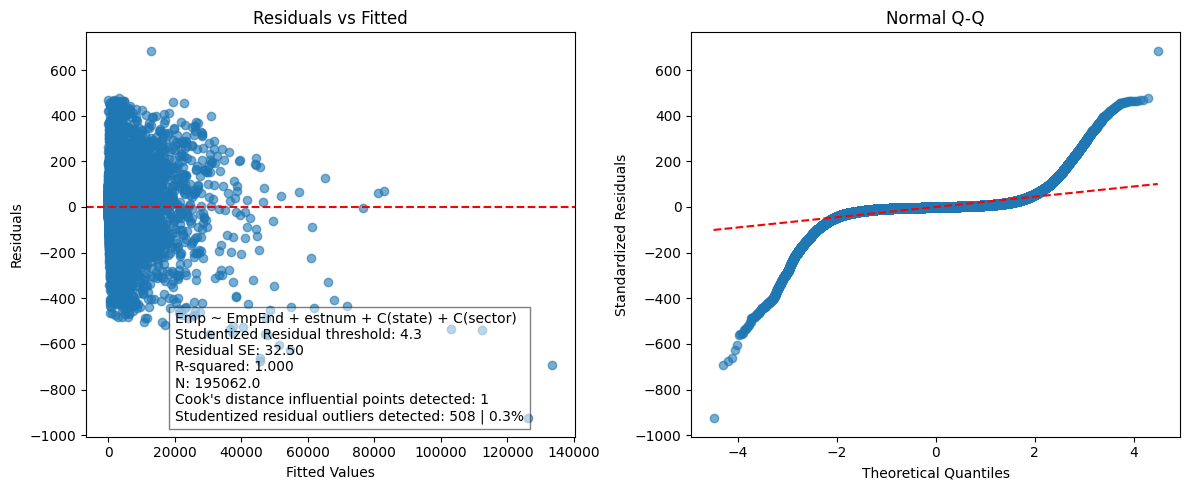

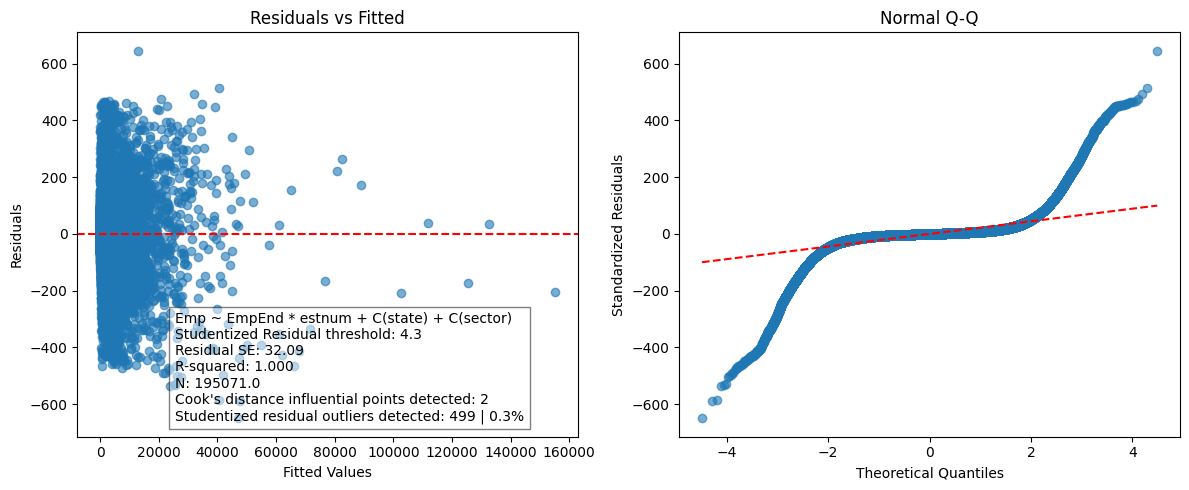

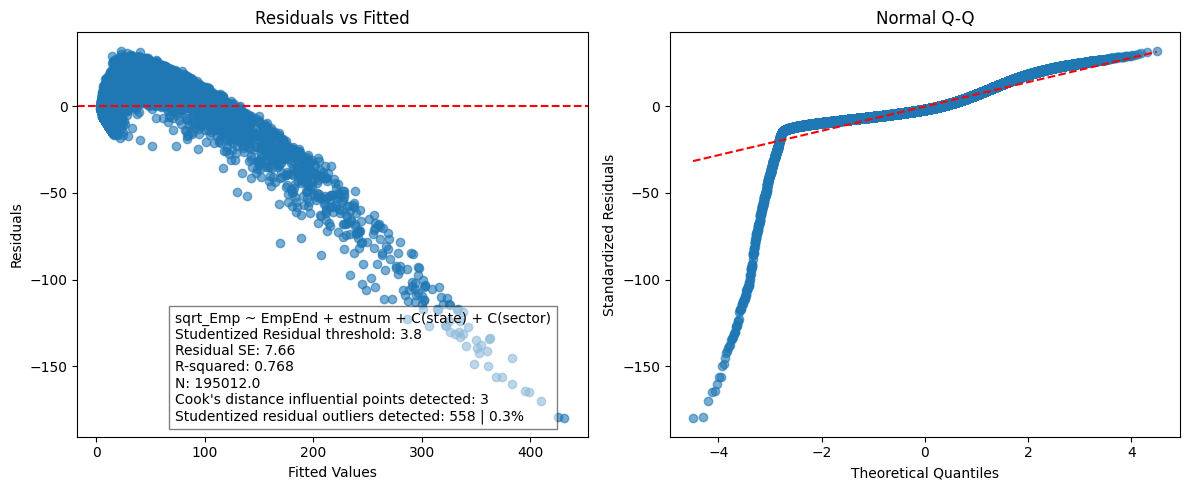

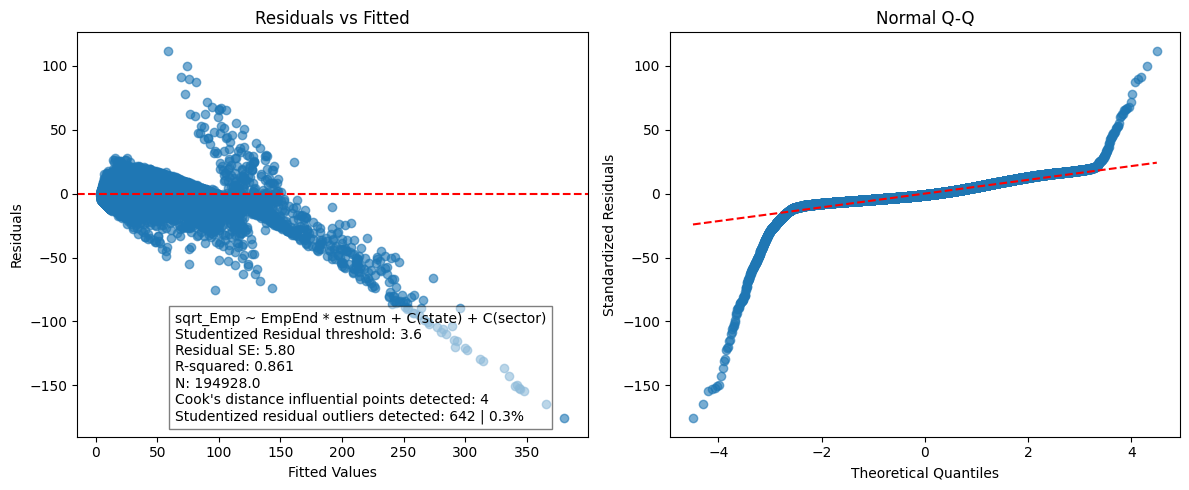

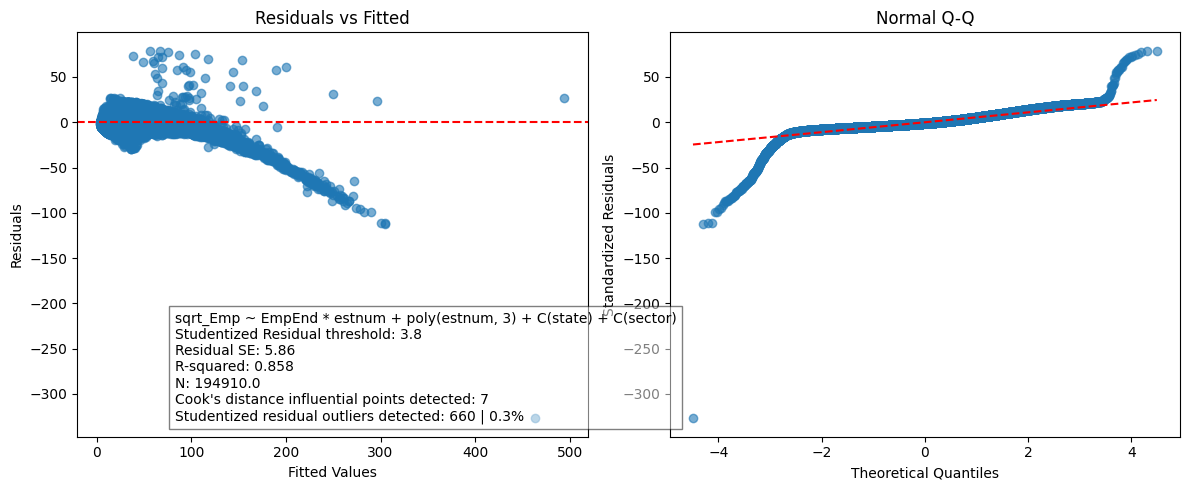

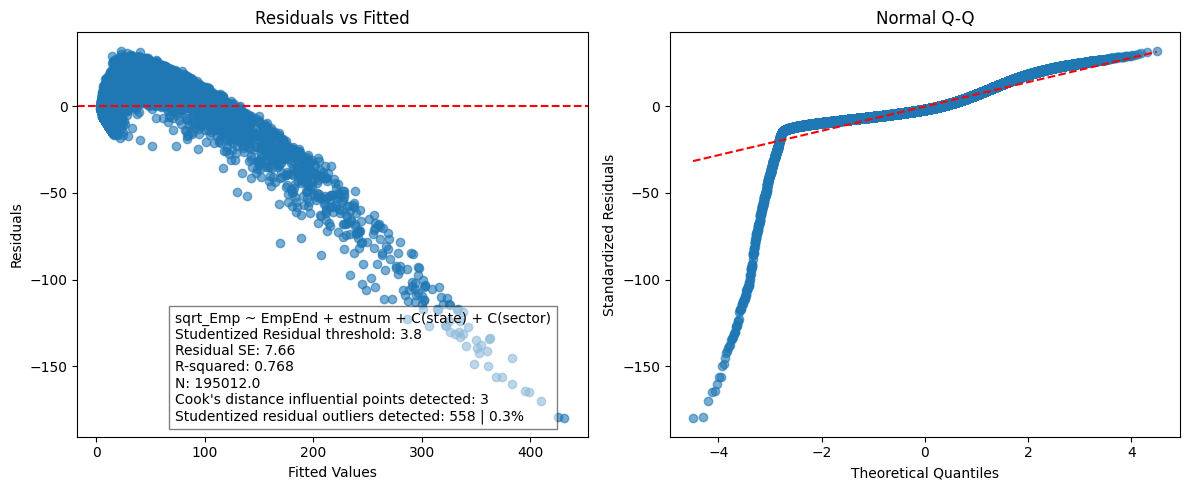

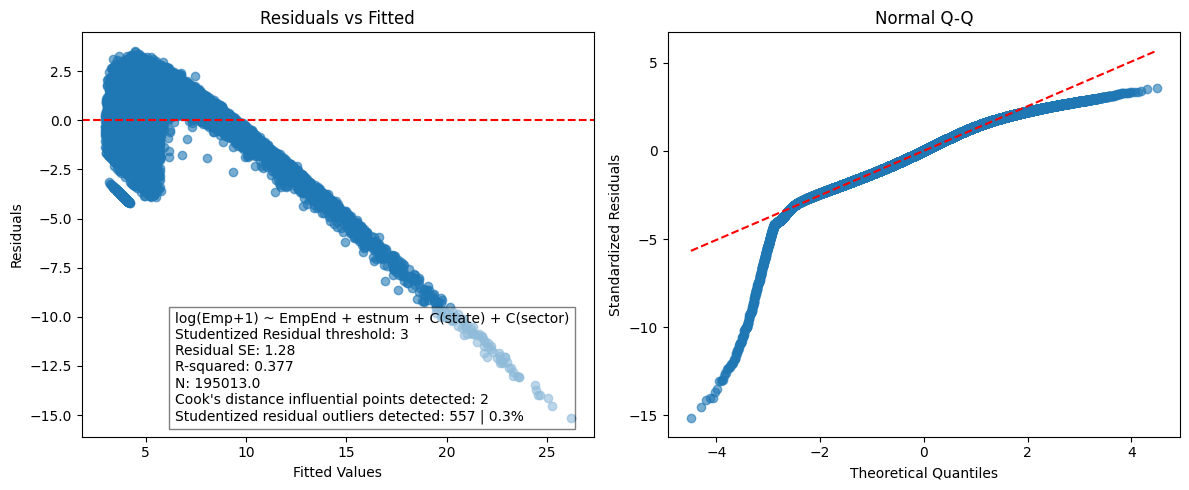

In [4]:
# ############## Employment Counts ################
# # Step 1: Create employment prediction model
empfunc.employmentConfig.TESTFORMULAS = True
empfunc.employmentConfig.OUTLIER_THRESH = 4.3
empfunc.employmentConfig.OLS_FORMULA = "Emp ~ EmpEnd + estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)
empfunc.employmentConfig.OUTLIER_THRESH = 4.3
empfunc.employmentConfig.OLS_FORMULA = "Emp ~ EmpEnd * estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)
empfunc.employmentConfig.OUTLIER_THRESH = 3.8
empfunc.employmentConfig.OLS_FORMULA = "sqrt_Emp ~ EmpEnd + estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)
empfunc.employmentConfig.OUTLIER_THRESH = 3.6
empfunc.employmentConfig.OLS_FORMULA = "sqrt_Emp ~ EmpEnd * estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)
empfunc.employmentConfig.OUTLIER_THRESH = 3.8
empfunc.employmentConfig.OLS_FORMULA = "sqrt_Emp ~ EmpEnd * estnum + poly(estnum, 3) + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)
empfunc.employmentConfig.OUTLIER_THRESH = 3.8
empfunc.employmentConfig.OLS_FORMULA = "sqrt_Emp ~ EmpEnd + estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)

empfunc.employmentConfig.OUTLIER_THRESH = 3
empfunc.employmentConfig.OLS_FORMULA = "log(Emp+1) ~ EmpEnd + estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)


#### Observations
##### Linear Model with Untransformed Emp
- **Formula:** `Emp~EmpEnd + estnum + C(state) + C(sector)`
- **Key Findings:**
    - Shows minimal relationship bbetween residuals and fitted values
    - Achieves an almost perfect R<sup>2</sup> value
    - This is our preferred and default formula as it best meets linear model assumptions
##### Alternative Transformations
When testing other response variable transformations:
- **Square Root:** `sqrt_Emp ~ ...`
- **Log:** `log(Emp+1) ~ ...`

Issues observed
- Residuals vs fitted plots show near-linear patterns
- Gross violations of linear model assumptions
- While these transformations reduced RSE, they created other problems.
##### Interaction terms
- Tested `Emp * estnum` interaction:
    - Made little difference in model performance
    - Available option but not significantly beneficial


Before we move on, lets fit the model on our default values.

In [22]:
empfunc.employmentConfig.TESTFORMULAS = False
empfunc.employmentConfig.OUTLIER_THRESH = 4.3
empfunc.employmentConfig.OLS_FORMULA = "Emp ~ EmpEnd + estnum + C(state) + C(sector)"
m1empfit = empfunc.get_m1emp_model(df=df4)

Filtered out the following indices due to influence (Cook's Distance): [12003]
Outliers detected and removed: 508


## Noise Coefficient Impact on m2emp imputation
### Understanding the Noise Mechanism
The noise coefficient affects month 2 employment (`m2emp`) imputation in `get_m2emp()` through this key calculation:
```python
noisesd = np.sqrt((noisecoef * 2 * np.abs(m1emp_nz - m3emp_nz)) / (m1emp_nz + m3emp_nz))
```
### How the Noise works:
1. **Base Relationship:**
    - `m2emp` is fundamentally calculated as the midpoint between m1 and m3emp
    - Without noise: `m2emp = m1emp + (m3emp - m1emp)/2`
2. **Noise Addition:**
    - The function adds normally distributed noise centered at 0 with standard deviation `noisesd`
    - The magnitude of this noise is controlled by the `noisecoef` parameter
3. **Noise Scaling Factor**
    - The noise scales with:
        - Absolute difference between m1 and m3 emplotment (`|m1emp_nz-m3emp_nz|`)
    - This creates proportionally larger noise for:
        - Bigger employment changes between months
        - Industries where counts are more volatile
        
##### Lets test the output of the month to month employment imputation over a variety of noise coeficients

In [25]:
import pandas as pd
import numpy as np
## Plots are less useful with the smaller array
noise_coefs = [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20, 25, 30, 35, 500.0]

## - For looking at general trends with the plots 
## - most of the metrics (mean abs diff, mean sq diff, std sq/abs diff,...)grow linearly
## - Will take much longer to run
# noise_coefs = np.arange(00, 500, 5).tolist()
results = {}

for coef in noise_coefs:

    empMat = empfunc.get_employmentCounts4(
        df4,
        m1emp_model=m1empfit,
        m2emp_noisecoef=coef,
        rseed=5,
        include_m1emp_indicator=True
    )

    imputed_rows = empMat[empMat['m1empFromModel'] == 1].copy()
    
    imputed_rows['abs_diff_m1m2'] = (imputed_rows['m2emp'] - imputed_rows['m1emp']).abs()
    imputed_rows['sq_diff_m1m2'] = (imputed_rows['m2emp']-imputed_rows['m1emp'])**2

    results[f"coef_{coef}"] = imputed_rows

comparison = pd.DataFrame({
    'noise_coef': noise_coefs,
    'mean_m1emp': [results[f"coef_{c}"]['m1emp'].mean() for c in noise_coefs],
    'mean_m2emp': [results[f"coef_{c}"]['m2emp'].mean() for c in noise_coefs],
    'std_m2emp': [results[f"coef_{c}"]['m2emp'].std() for c in noise_coefs],
    'mean_abs_diff_m1m2': [results[f"coef_{c}"]['abs_diff_m1m2'].mean() for c in noise_coefs],
    'ms_diff_m1m2': [results[f"coef_{c}"]['sq_diff_m1m2'].mean() for c in noise_coefs],
    'std_abs_diff_m1m2': [results[f"coef_{c}"]['abs_diff_m1m2'].std() for c in noise_coefs],
    'std_sq_diff_m1m2': [results[f"coef_{c}"]['sq_diff_m1m2'].std() for c in noise_coefs],
})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("\nComparison across noise coefficients (only imputed rows):")
print(comparison)



Comparison across noise coefficients (only imputed rows):
    noise_coef  mean_m1emp  mean_m2emp  std_m2emp  mean_abs_diff_m1m2  \
0         0.50       58.87       57.92     202.71                1.77   
1         1.00       58.87       57.92     202.71                1.78   
2         2.00       58.87       57.93     202.71                1.81   
3         5.00       58.87       57.95     202.70                1.89   
4        10.00       58.87       57.99     202.69                2.04   
5        15.00       58.87       58.02     202.69                2.18   
6        20.00       58.87       58.05     202.68                2.30   
7        25.00       58.87       58.08     202.68                2.42   
8        30.00       58.87       58.11     202.67                2.53   
9        35.00       58.87       58.14     202.67                2.63   
10      500.00       58.87       59.82     202.46                6.63   

    ms_diff_m1m2  std_abs_diff_m1m2  std_sq_diff_m1m2  
0       

Reading this output
- `noise coef`: The noise coefficient
- `mean_m1emp`: The mean of all the m1emps (This should stay constant)
- `mean_m2emp`: The mean of all the m2emps
- `std_m2emp`: The Standard Deviation of all the m2emps
- `mean_abs_diff_m1m2`: The mean absolute difference between m1emp and m2emp
- `ms_diff_m1m2`: The mean squared difference between m1emp and m2emp
- `std_abs_diff_m1m2`: The Standard Deviation of all the |m1emp-m2emp|
- `std_sq_diff_m1m2`: The Standard Deviation of all the (m1emp-m2emp)$^2$
### Key Observations from the Results
1. **Minimal Imppact on Mean Employment**:
    - Across all noise coefficients (0.5 to 500), `mean_m2emp` stays close to `mean_m1emp` (58.87), showing the noise is mean-preserving (by design).
    - Even at `noise_coef=500`, the mean only drifts to 59.82 (a 1.6% change), which suggests extreme values are unnecessary.
2. **Stable Standard Deviation**:
    - `std_m2emp` remains nearly constant (~202.7) across all coefficients.
    - This confirms the noise primarily affects month-to-month variability (differences between `m1emp` and `m2emp`), not overall dispersion.
3. **Balanced Absolute Differences** (`mean_abs_diff_m1m2`)
    - At `noise_coef=1.0`: 1.78
    - At `noise_coef=5.0`: 1.89 (A ~6% increase)
    - At `noise_coef=500.0`: 6.63 (A ~272% increase)
    - **Conclusion**: Noise coefficients can be changed to produce more realistic month to month fluctuations, but extreme values introduce implausible volatility.
    
4. **Squared Differences Highlight Outliers**
    - `ms_diff_m1m2` jumps from 7.74 (`noise_coef=1.0`) to 106.95 (`noise_coef=500`).
    - This shows that higher coefficients possibly create extreme outliers (e.g., large/unusual employment swings), which are likely unrealistic.
### Practical Implications:
1. **Extreme Values**:
    - Even at noise_coef=500, the mean abs difference only reaches ~6.6 (11.2% of Mean Employment)
        - Which still seems exceptionally large outside of major events where typical fluctuations should rarely be over 5% in a month
    - The mean squared difference exaggerates this unrealistically volatile month to month employment
2. **Recommmendation**:
    - Value between 1-5 appear most reasonable based on the test results
    - `mean_abs_diff_m1m2` = ~1.78-1.89 (about 3-3.3% of Mean Employment (58.87))
    
Below, we can see some plots to see how our various metrics scale with the noise coefficient.

**NOTE:** With the standard `noise_coef` array, we skip from 35 to 500, making for some incomplete plots.
- If you want to look at the plots use the commented `noise_coef` array to see the complete graphs.
- This will take a while as we are caluculating these metrics over 100 `noise_coef` values

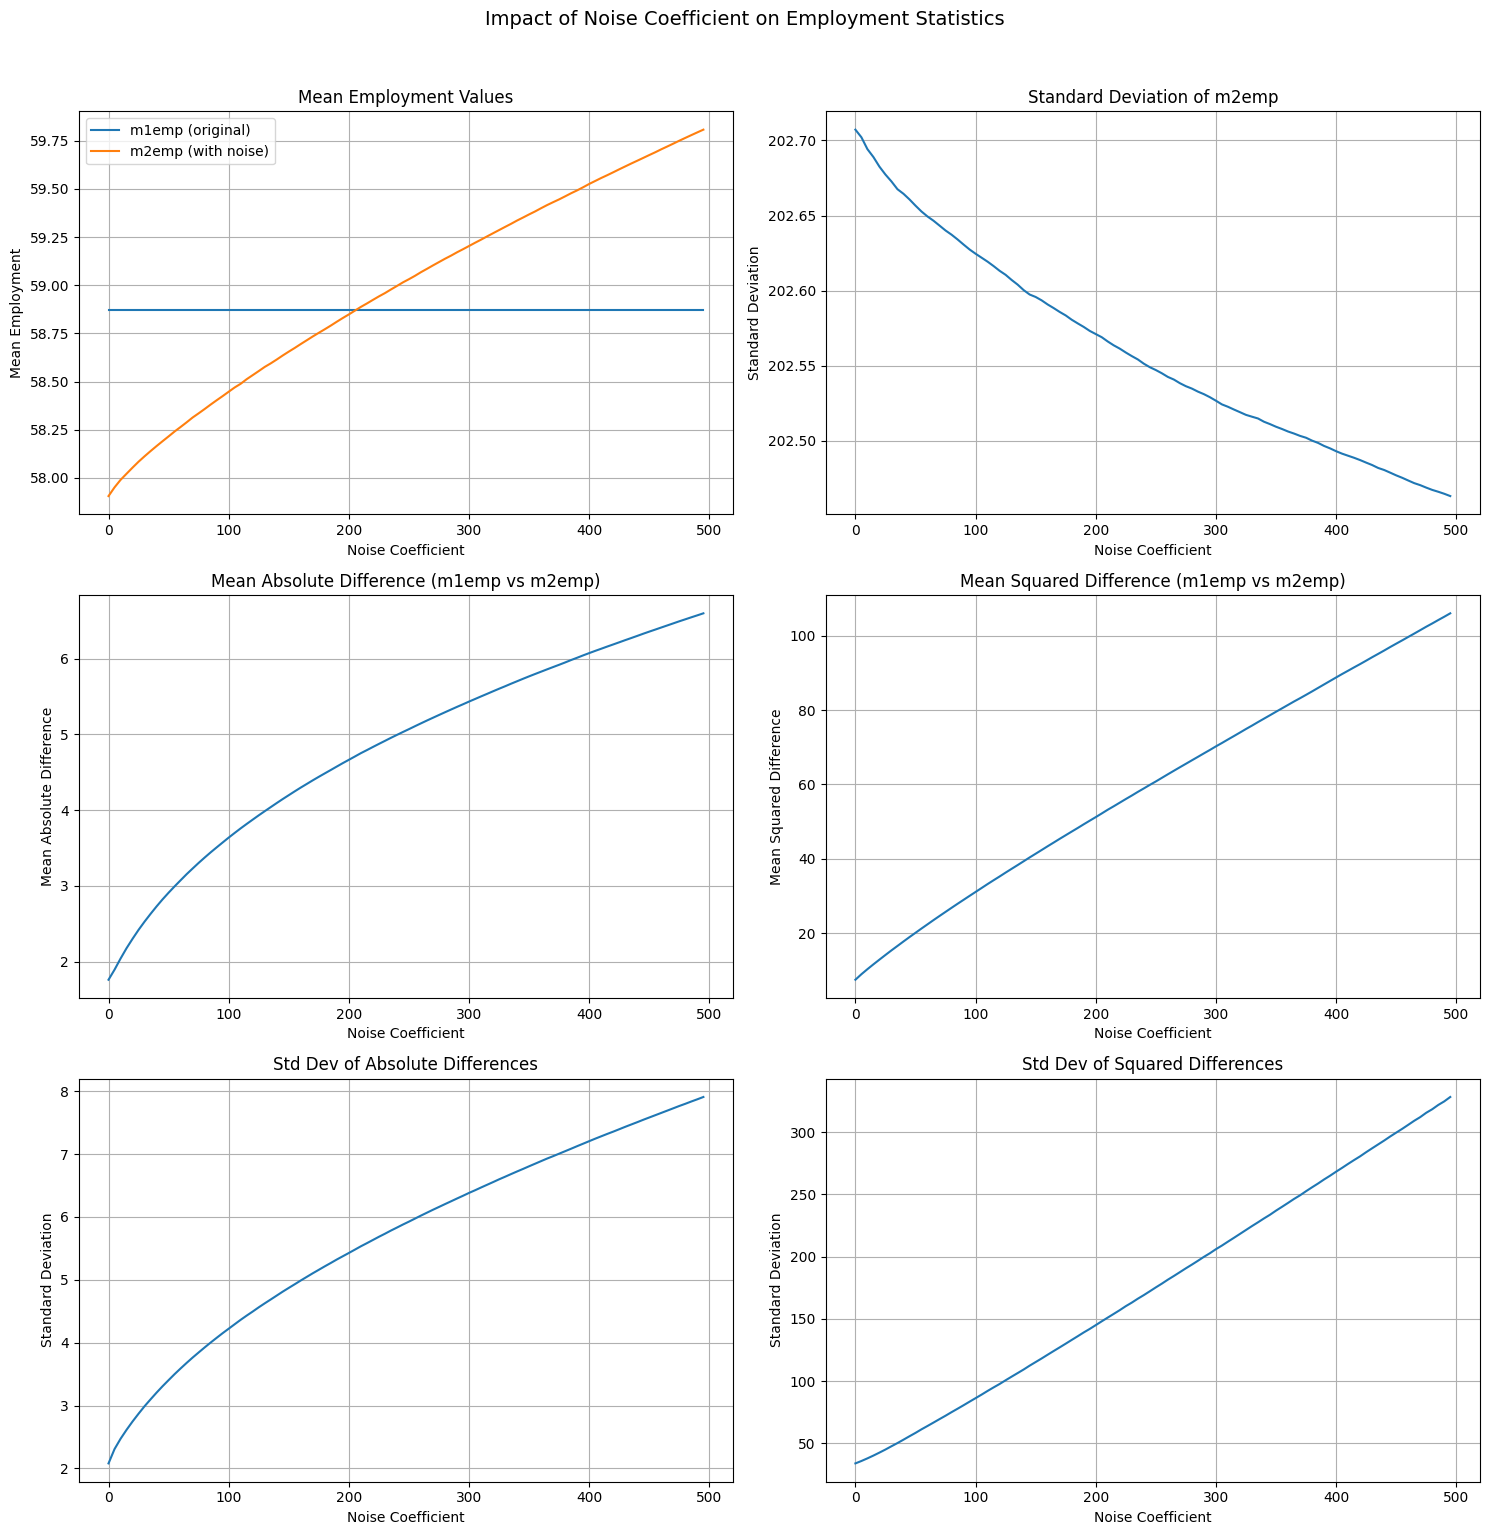

In [24]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle('Impact of Noise Coefficient on Employment Statistics', y=1.02, fontsize=14)

# Plot 1: Mean employment values
axes[0,0].plot(comparison['noise_coef'], comparison['mean_m1emp'], label='m1emp (original)')
axes[0,0].plot(comparison['noise_coef'], comparison['mean_m2emp'], label='m2emp (with noise)')
#axes[0,0].set_xscale('log')
axes[0,0].set_title('Mean Employment Values')
axes[0,0].set_xlabel('Noise Coefficient')
axes[0,0].set_ylabel('Mean Employment')
axes[0,0].legend()
axes[0,0].grid(True, which="both", ls="-")

# Plot 2: Standard deviation of m2emp
axes[0,1].plot(comparison['noise_coef'], comparison['std_m2emp'])
#axes[0,1].set_xscale('log')
axes[0,1].set_title('Standard Deviation of m2emp')
axes[0,1].set_xlabel('Noise Coefficient')
axes[0,1].set_ylabel('Standard Deviation')
axes[0,1].grid(True, which="both", ls="-")

# Plot 3: Mean absolute difference between m1 and m2
axes[1,0].plot(comparison['noise_coef'], comparison['mean_abs_diff_m1m2'])
#axes[1,0].set_xscale('log')
axes[1,0].set_title('Mean Absolute Difference (m1emp vs m2emp)')
axes[1,0].set_xlabel('Noise Coefficient')
axes[1,0].set_ylabel('Mean Absolute Difference')
axes[1,0].grid(True, which="both", ls="-")

# Plot 4: Mean squared difference between m1 and m2
axes[1,1].plot(comparison['noise_coef'], comparison['ms_diff_m1m2'])
#axes[1,1].set_xscale('log')
axes[1,1].set_title('Mean Squared Difference (m1emp vs m2emp)')
axes[1,1].set_xlabel('Noise Coefficient')
axes[1,1].set_ylabel('Mean Squared Difference')
axes[1,1].grid(True, which="both", ls="-")

# Plot 5: Standard deviation of absolute differences
axes[2,0].plot(comparison['noise_coef'], comparison['std_abs_diff_m1m2'])
#axes[2,0].set_xscale('log')
axes[2,0].set_title('Std Dev of Absolute Differences')
axes[2,0].set_xlabel('Noise Coefficient')
axes[2,0].set_ylabel('Standard Deviation')
axes[2,0].grid(True, which="both", ls="-")

# Plot 6: Standard deviation of squared differences
axes[2,1].plot(comparison['noise_coef'], comparison['std_sq_diff_m1m2'])
#axes[2,1].set_xscale('log')
axes[2,1].set_title('Std Dev of Squared Differences')
axes[2,1].set_xlabel('Noise Coefficient')
axes[2,1].set_ylabel('Standard Deviation')
axes[2,1].grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

This step sets up our dataframe for the next step. You can read about `adjust_countytotal_qwi()` in the `EmploymentFunctions.py` file

In [26]:
# Step 2: Generate monthly employment counts
empMat = empfunc.get_employmentCounts4(
    df4,
    m1emp_model=m1empfit,
    m2emp_noisecoef=empfunc.employmentConfig.M2EMP_NOISECOEF,
    rseed=None,
    include_m1emp_indicator=True
)
# Step 3: Adjust to match county totals
adjustdf = pd.DataFrame(empMat)
adjustdf = adjustdf.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name and 'm' in col.name else col)
adjustm1emp = empfunc.adjust_countytotal_qwi(valdf=adjustdf, sumdf=df[df["industry"] == "------"])
empMatA = empMat.copy() 
empMatA.iloc[:, 1] = adjustm1emp # Update with adjusted values


## Wage Imputation

### Model Fitting

The wage imputation pipeline begins with model fitting in `get_wage_model()`, which has three configurable parameters available in `config.yaml`:

```yaml
wageConfig:
  OLS_FORMULA: "sqrt_wagediff ~ wageCBP_missing6by4*m3emp + poly(m3emp, degree=3) + C(sector) + C(state)"
  COOKS_THRESH: 1.0
  OUTLIER_THRESH: 6.7
```

We will first look at the Normal Q-Q and Fitted over Residual plots for a variety of possible formula choices.
For now the threshold for filtering based on Cook's distance is the default 1.0, and the threshold for filtering based on Studentized residuals is selected so that we remove about 0.3% of the data

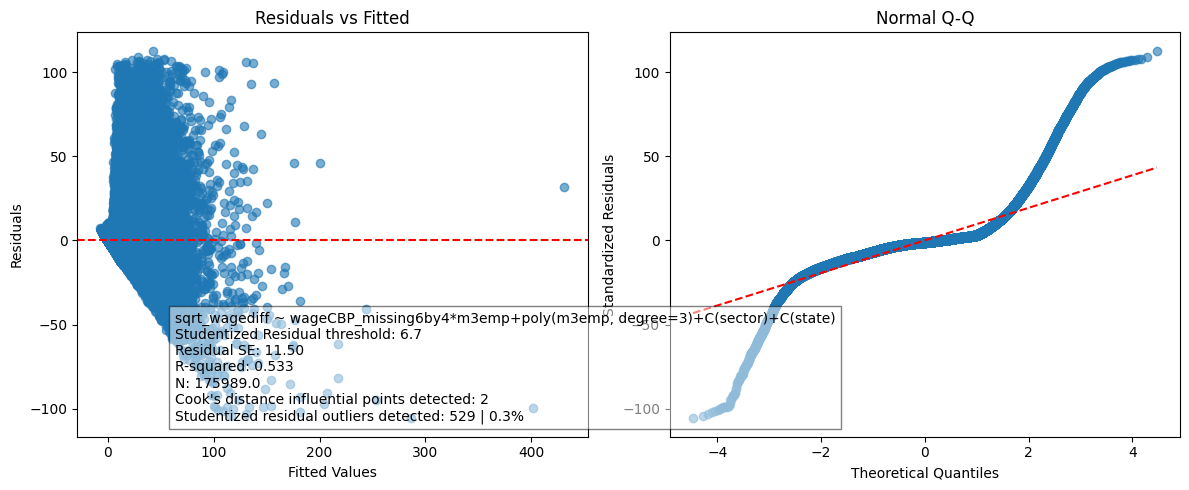

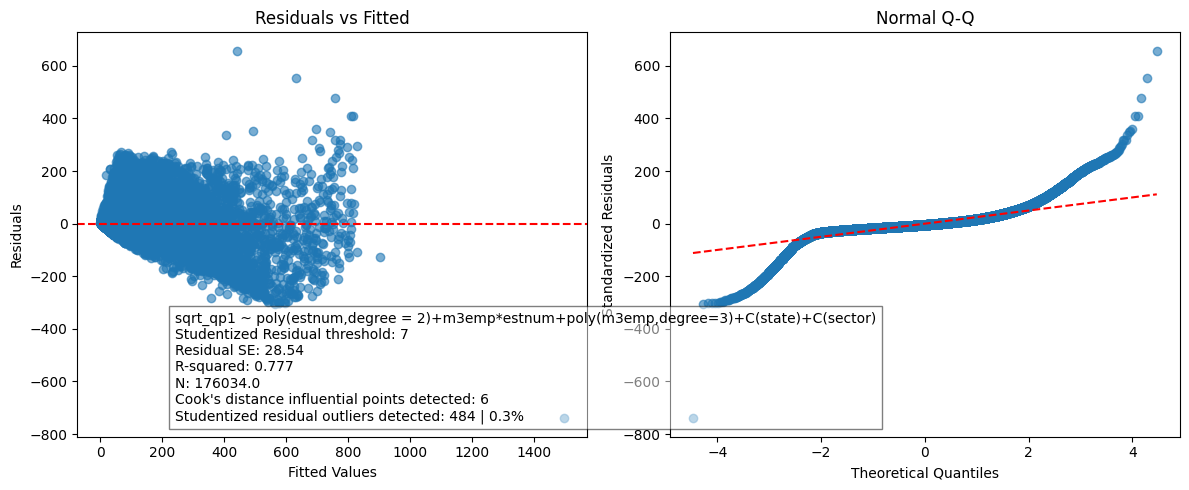

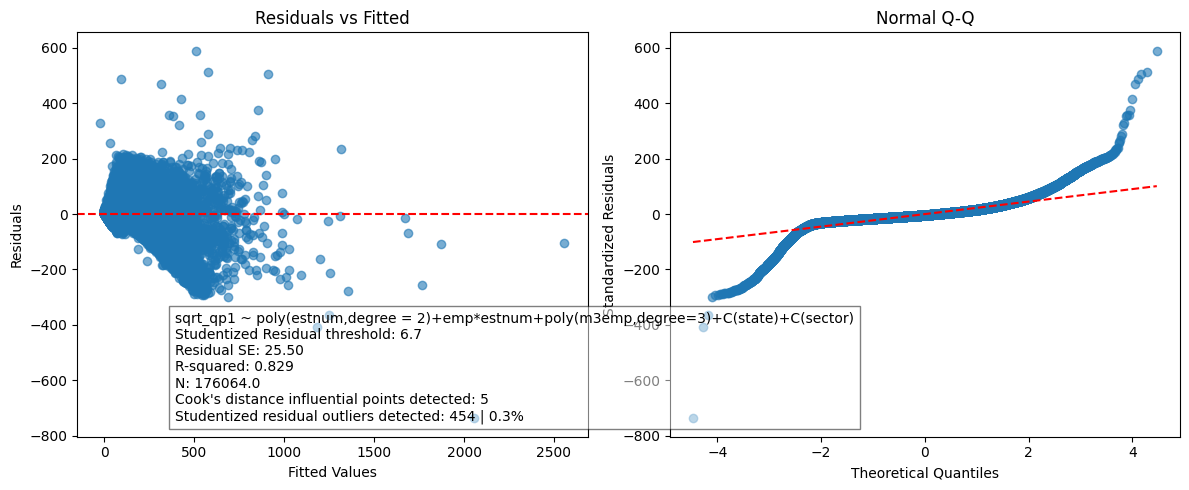

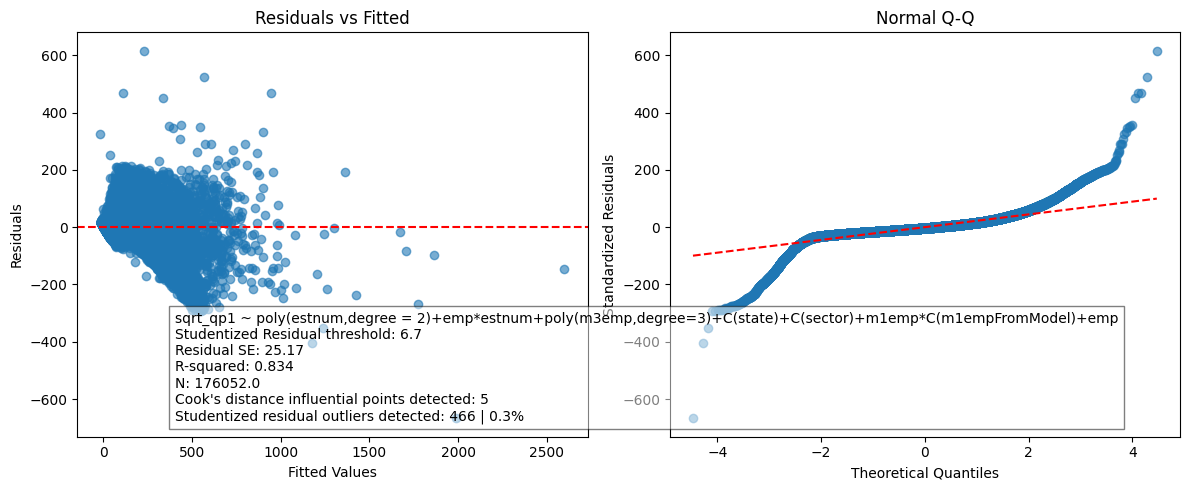

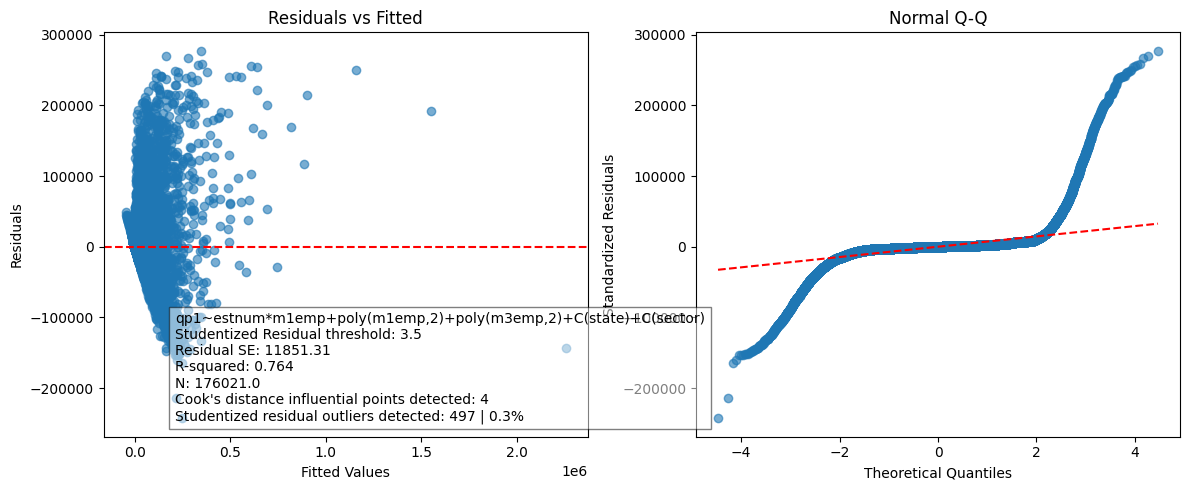

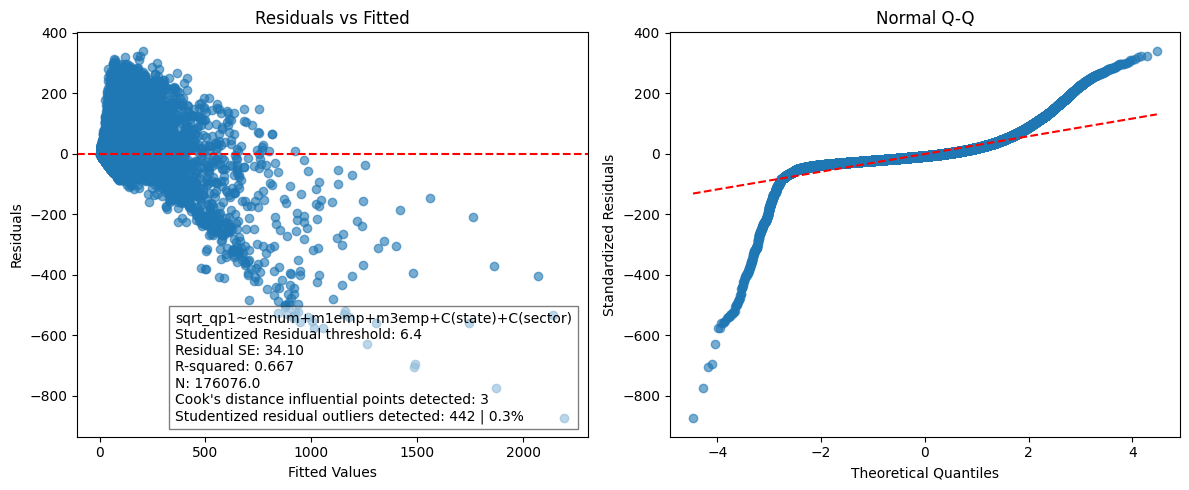

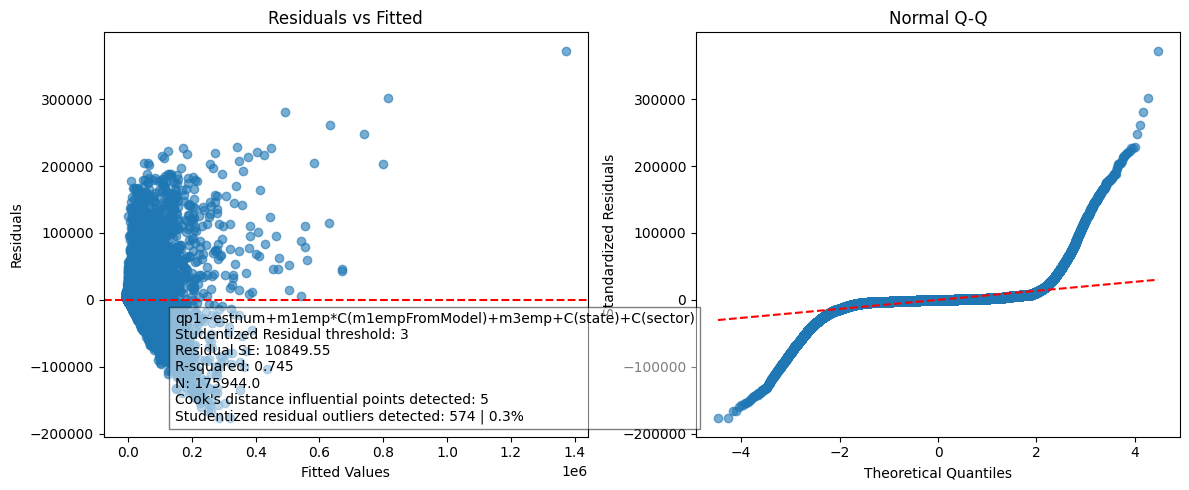

In [27]:
wagefunc.wageConfig.TESTFORMULAS = True
wagefunc.wageConfig.OUTLIER_THRESH = 6.7
wagefunc.wageConfig.OLS_FORMULA = "sqrt_wagediff ~ wageCBP_missing6by4*m3emp+poly(m3emp, degree=3)+C(sector)+C(state)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 7
wagefunc.wageConfig.OLS_FORMULA = "sqrt_qp1 ~ poly(estnum,degree = 2)+m3emp*estnum+poly(m3emp,degree=3)+C(state)+C(sector)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 6.7
wagefunc.wageConfig.OLS_FORMULA = "sqrt_qp1 ~ poly(estnum,degree = 2)+emp*estnum+poly(m3emp,degree=3)+C(state)+C(sector)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 6.7
wagefunc.wageConfig.OLS_FORMULA = "sqrt_qp1 ~ poly(estnum,degree = 2)+emp*estnum+poly(m3emp,degree=3)+C(state)+C(sector)+m1emp*C(m1empFromModel)+emp"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 3.5
wagefunc.wageConfig.OLS_FORMULA = "qp1~estnum*m1emp+poly(m1emp,2)+poly(m3emp,2)+C(state)+C(sector)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 6.4
wagefunc.wageConfig.OLS_FORMULA = "sqrt_qp1~estnum+m1emp+m3emp+C(state)+C(sector)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)
wagefunc.wageConfig.OUTLIER_THRESH = 3
wagefunc.wageConfig.OLS_FORMULA = "qp1~estnum+m1emp*C(m1empFromModel)+m3emp+C(state)+C(sector)"
wagefit_sub = wagefunc.get_wage_model(df=df4, emp_mat_adj = empMatA)


In [6]:

naics6df = pd.read_csv("./DataNAICS6.csv", nrows=10000)
random.seed(5)
getmd.microdataConfig.GAM_SHAPE = 100
getmd.microdataConfig.GAM_SCALE = 200
tempdf = getmd.make_syn_microdata(naics6df,numchunk=1,outfoldername=getmd.microdataConfig.OUTPATH)
# Generate stats
summary = summarize_microdata(tempdf)
print(summary)
# ################## Microdata Postprocessing #######################
# print('---------- Generating Final Microdata ----------')
# combine_and_split_iterative(yr=2016, qtr=1)


       Mean m1emp  Median m1emp  Std m1emp  Min m1emp  Max m1emp  \
Value   15.360439           8.0  43.952399        0.0     5392.0   

       Zero-employers (m1emp)   Mean wage     Std wage  \
Value                     921  362.359515  5839.444429   

       Correlation (m1emp vs wage)  
Value                      0.22443  
---------- Making Synthetic Microdata ----------
This may take a while, please be patient...
starting make_syn_microdata: chunk size=10000
split data frame checkpoint
Data set 1 took 10.488176822662354  to process.
       Mean m1emp  Median m1emp  Std m1emp  Min m1emp  Max m1emp  \
Value   15.356705           8.0  43.746545        0.0     5392.0   

       Zero-employers (m1emp)   Mean wage     Std wage  \
Value                     931  362.360234  5829.594442   

       Correlation (m1emp vs wage)  
Value                     0.224469  
